In [11]:
from keras.utils import np_utils
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
import numpy as np
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1,1,28,28)/255
x_test = x_test.reshape(-1,1,28,28)/255

In [6]:
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [12]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [13]:
from keras.models import model_from_json
model.load_weights('vgg_face_weights.h5')


In [14]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img
def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [15]:
vgg_ear_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [21]:
epsilon = 0.20

def verifyEar(img1, img2):
    img1_representation = vgg_ear_descriptor.predict(preprocess_image('Cropped/%s' % (img1)))[0,:]
    img2_representation = vgg_ear_descriptor.predict(preprocess_image('Cropped/%s' % (img2)))[0,:]
    
    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
    
    print("Cosine similarity: ",cosine_similarity)
    print("Euclidean distance: ",euclidean_distance)
    
    if(cosine_similarity < epsilon):
        print("verified... they are same person")
    else:
        print("unverified! they are not same person!")
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(image.load_img('Cropped/%s' % (img1)))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(image.load_img('Cropped/%s' % (img2)))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    print("-----------------------------------------")

Cosine similarity:  0.11075633764266968
Euclidean distance:  32.379593
verified... they are same person


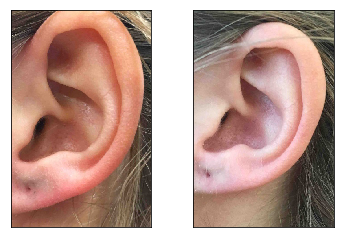

-----------------------------------------


In [22]:
verifyEar("001_.jpg","001_t.jpg")

Cosine similarity:  0.24004191160202026
Euclidean distance:  49.301937
unverified! they are not same person!


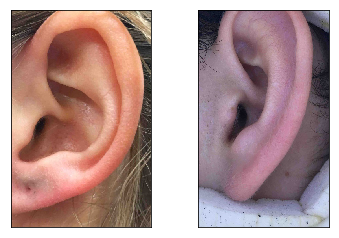

-----------------------------------------


In [23]:
verifyEar("001_.jpg", "005_dt.jpg")